---
title: C++ 网络编程 send 和 recieve 的阻塞模式
tags: 小书匠,c++,network,read,write,send,recv,recieve
grammar_cjkRuby: true
renderNumberedHeading: true
---

[toc]

# C++ 网络编程 send 和 recieve 的阻塞模式

##  缓冲区

- 每个 socket 被创建后，都会分配两个缓冲区，输入缓冲区和输出缓冲区。

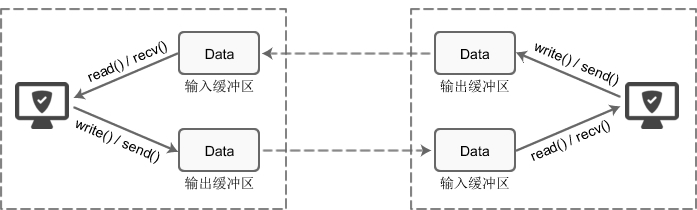

-  write()/send() 并不立即向网络中传输数据，而是先将数据写入缓冲区中，再由TCP协议将数据从缓冲区发送到目标机器。
-  一旦将数据写入到缓冲区，函数就可以成功返回，不管它们有没有到达目标机器，也不管它们何时被发送到网络，这些都是TCP协议负责的事情。
-  TCP协议独立于 write()/send() 函数，数据有可能刚被写入缓冲区就发送到网络，也可能在缓冲区中不断积压，多次写入的数据被一次性发送到网络，这取决于当时的网络情况、当前线程是否空闲等诸多因素，不由程序员控制。
-  read()/recv() 函数也是如此，也从输入缓冲区中读取数据，而不是直接从网络中读取

### I/O 缓冲区的一些特点
-  I/O缓冲区在每个TCP套接字中单独存在；
-  I/O缓冲区在创建套接字时自动生成；
-  即使关闭套接字也会继续传送输出缓冲区中遗留的数据； 
- 关闭套接字将丢失输入缓冲区中的数据。

## send 的过程

对于TCP套接字（默认情况下），当使用 write()/send() 发送数据时： 

1. 首先会检查缓冲区，如果缓冲区的可用空间长度小于要发送的数据，那么 write()/send() 会被阻塞（暂停执行），直到缓冲区中的数据被发送到目标机器，腾出足够的空间，才唤醒 write()/send() 函数继续写入数据。  
2. 如果TCP协议正在向网络发送数据，那么输出缓冲区会被锁定，不允许写入，write()/send() 也会被阻塞，直到数据发送完毕缓冲区解锁，write()/send() 才会被唤醒。 
3. 如果要写入的数据大于缓冲区的最大长度，那么将分批写入。  
4. 直到所有数据被写入缓冲区 write()/send() 才能返回。  [c.biancheng.net]

也就是说，send 实际上也是阻塞的，只不过因为一般情况下不会把缓冲区填满，因此不会表现出阻塞。

## recv 的过程

当使用 read()/recv() 读取数据时： 
1. 首先会检查缓冲区，如果缓冲区中有数据，那么就读取，否则函数会被阻塞，直到网络上有数据到来。  
2. 如果要读取的数据长度小于缓冲区中的数据长度，那么就不能一次性将缓冲区中的所有数据读出，剩余数据将不断积压，直到有 read()/recv() 函数再次读取。 
3. 直到读取到数据后 read()/recv() 函数才会返回，否则就一直被阻塞。

这就是TCP套接字的阻塞模式。所谓阻塞，就是上一步动作没有完成，下一步动作将暂停，直到上一步动作完成后才能继续，以保持同步性。

# References
- [socket缓冲区以及阻塞模式_C语言中文网](http://c.biancheng.net/cpp/html/3040.html)
- [C/C++网络编程，从socket到epoll_哔哩哔哩 (゜-゜)つロ 干杯~-bilibili](https://www.bilibili.com/video/BV11Z4y157RY?p=13)